## LRU U-Net Tutorial
This tutorial walks through building a simple 1D U‑Net‑style audio denoiser that uses the Linear Recurrent Unit (LRU) as its core sequence model. 

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Audio, display
import soundfile as sf


from lrnnx.architectures.lru_unet import LRUUnet

## Dataset for Denoising
Generates synthetic mono audio clips of fixed duration, where each sample is a pair (noisy, clean). For every index, it:

Creates a 1D time axis of length max_length corresponding to max_length / sample_rate seconds of audio.

Synthesizes a clean signal as a sum of a random fundamental sinusoid (200–400 Hz) and its 2× and 3× harmonics, modulated by an exponentially decaying envelope.

Adds white Gaussian noise at a random noise level, then peak-normalizes both clean and noisy signals.

Returns (noisy, clean) as float32 tensors of shape (max_length,).

In [2]:
class AudioDenoisingDataset(Dataset):
    """Synthetic noisy/clean 1D audio pairs."""

    def __init__(self, sample_rate: int = 16000, max_length: int = 16000, num_samples: int = 1000):
        self.sample_rate = sample_rate
        self.max_length = max_length
        self.num_samples = num_samples
        print(f"Using synthetic data with {num_samples} samples")

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx):
        return self._generate_synthetic_sample()

    def _generate_synthetic_sample(self):
        duration = self.max_length / self.sample_rate
        t = np.linspace(0, duration, self.max_length)

        # fundamental + harmonics
        freq1 = np.random.uniform(200, 400)
        freq2 = freq1 * 2
        freq3 = freq1 * 3

        clean = (
            np.sin(2 * np.pi * freq1 * t) +
            0.5 * np.sin(2 * np.pi * freq2 * t) +
            0.3 * np.sin(2 * np.pi * freq3 * t)
        )

        # exponential decay envelope
        envelope = np.exp(-t * np.random.uniform(0.5, 2.0))
        clean *= envelope

        # add white noise
        noise_level = np.random.uniform(0.1, 0.4)
        noise = np.random.normal(0, noise_level, len(clean))
        noisy = clean + noise

        # normalize
        clean = clean / (np.abs(clean).max() + 1e-8)
        noisy = noisy / (np.abs(noisy).max() + 1e-8)

        return (
            torch.tensor(noisy, dtype=torch.float32),
            torch.tensor(clean, dtype=torch.float32),
        )

## Training
Selects one batch (noisy, clean) from the provided dataset and reshapes it to (B, 1, L) for a 1D model input.

Moves the model and data to the chosen device (CPU or CUDA), sets up an Adam optimizer and MSE loss.

Trains the model on this single sample for steps iterations, updating parameters each step and logging the loss, in order to verify that the network can fit one example (i.e., the loss should go down towards zero).

In [3]:
def train_audio_denoiser(
    model: nn.Module,
    dataset: Dataset,
    epochs: int = 1,           
    batch_size: int = 1,
    learning_rate: float = 1e-2,
    device: str = "auto",
    steps: int = 1000,         
):
    """
    Overfit a denoising model on a single synthetic audio sample to verify it can learn.
    
    Uses fixed batch from dataset for steps gradient updates. Logs loss history.
    Designed as a sanity-check: loss should drop toward zero on one example.
    """
    # Auto-detect device (GPU if available, else CPU)
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    print(f"Training on device: {device}")

    # Create dataloader but only use first batch (overfitting experiment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Move model to device and setup MSE loss + Adam optimizer
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Extract single batch once: (B, L) -> add channel dim -> (B, 1, L)
    noisy, clean = next(iter(dataloader))
    noisy = noisy.unsqueeze(1).to(device)   # (1, 1, L)
    clean = clean.unsqueeze(1).to(device)   # (1, 1, L) - target for MSE

    # Track training loss over all steps
    history = {"losses": []}

    print(f"Overfitting on a single sample for {steps} steps...")
    model.train()
    for step in range(steps):
        # Standard PyTorch training step
        optimizer.zero_grad()
        outputs = model(noisy)  # Forward: (1, 1, L) -> (1, 1, L)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()

        # Log loss history
        history["losses"].append(loss.item())
        if (step + 1) % 50 == 0 or step == 0:
            print(f"Step {step+1}/{steps}, Loss: {loss.item():.8f}")

    return model, history


## Visualisation
visualize_denoising inspects how well the denoising model reconstructs a given audio sample, both visually and audibly. It:

Fetches a single (noisy, clean) clip from the dataset, runs the model on the noisy waveform (reshaped to (1, 1, L) and moved to the selected device), and converts the output back to NumPy.
​

Builds a shared time axis using the dataset’s sampling rate and plots three waveforms in Matplotlib: the noisy input, the clean target, and the model’s denoised output.
​

Computes MSE and SNR before and after denoising, prints the metrics, and uses IPython.display.Audio to play back the noisy, clean, and denoised signals inside a notebook, so both quantitative and qualitative effects of denoising can be inspected.
​

In [4]:
def visualize_denoising(
    model: nn.Module,
    dataset: Dataset,
    sample_idx: int = 0,
    device: str = "auto",
    figsize=(12, 8),
):
    """
    Visualize and evaluate denoising results for a single audio sample.
    
    Plots waveforms (noisy input, clean target, denoised output) and plays audio clips.
    Computes MSE and SNR improvement metrics.
    """
    # Auto-detect device (GPU if available, else CPU)
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # Set model to evaluation mode and move to target device
    model.eval()
    model.to(device)

    # Fetch specific sample from dataset: (noisy_tensor, clean_tensor) both shape (L,)
    noisy, clean = dataset[sample_idx]

    # Run inference: add batch/channel dims for model input (1, 1, L) -> output (1, 1, L)
    with torch.no_grad():
        noisy_batch = noisy.unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, L)
        denoised = model(noisy_batch).squeeze().cpu()  # Remove batch/channel dims -> (L,)

    # Convert tensors to NumPy for plotting and audio playback
    noisy_np = noisy.numpy()
    clean_np = clean.numpy()
    denoised_np = denoised.numpy()

    # Create shared time axis: t[i] = i / sample_rate (in seconds)
    sr = dataset.sample_rate
    t = np.linspace(0, len(noisy_np) / sr, len(noisy_np))

    # Create 3-subplot figure for waveform comparison
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot noisy input (red)
    axes[0].plot(t, noisy_np, "r-", alpha=0.7, label="Noisy")
    axes[0].set_title("Noisy audio")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True, alpha=0.3)

    # Plot clean target (green)
    axes[1].plot(t, clean_np, "g-", alpha=0.7, label="Clean")
    axes[1].set_title("Clean audio (target)")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(True, alpha=0.3)

    # Plot model output (blue) with time axis label on bottom plot
    axes[2].plot(t, denoised_np, "b-", alpha=0.7, label="Denoised")
    axes[2].set_title("Denoised audio (output)")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Amplitude")
    axes[2].grid(True, alpha=0.3)

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

    # Compute evaluation metrics
    mse = np.mean((denoised_np - clean_np) ** 2)  # Mean Squared Error
    noise_power = np.mean((noisy_np - clean_np) ** 2)  # Input noise power
    denoised_error = np.mean((denoised_np - clean_np) ** 2)  # Residual error after denoising

    # SNR = 10*log10(signal_power / noise_power); avoid div-by-zero
    orig_snr = 10 * np.log10(np.mean(clean_np ** 2) / (noise_power + 1e-10))
    den_snr = 10 * np.log10(np.mean(clean_np ** 2) / (denoised_error + 1e-10))

    # Play audio clips using IPython.display (works in Jupyter/Colab)
    print("\nPlaying noisy audio:")
    display(Audio(noisy_np, rate=sr))

    print("Playing clean target audio:")
    display(Audio(clean_np, rate=sr))

    print("Playing denoised audio:")
    display(Audio(denoised_np, rate=sr))

    # Print quantitative results
    print("Evaluation metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"Original SNR: {orig_snr:.2f} dB")
    print(f"Denoised SNR: {den_snr:.2f} dB")
    print(f"SNR improvement: {den_snr - orig_snr:.2f} dB")


## Quick inference helper
quick_denoise runs the trained denoising model on a real audio file for a fast, file‑based inference test. It:

Loads the waveform from audio_file using librosa.load, resampling to 16 kHz and returning a 1D NumPy array and sampling rate.
​

Converts the audio to a PyTorch tensor, reshapes it to (1, 1, L), moves it (and the model) to the selected device (CPU or CUDA), and performs a forward pass in no_grad mode.
​

Returns the original noisy waveform, the model’s denoised waveform (both as NumPy arrays) and the sampling rate, so the caller can save or listen to the result.

In [5]:
def quick_denoise(model: nn.Module, audio_file: str, device: str = "auto"):
    """
    Run denoising model on a real audio file for fast inference testing.
    
    Loads file at 16kHz, denoises, returns original + denoised waveforms + sample rate.
    Designed for quick "try it on my audio" demos after training.
    """
    # Auto-detect device (GPU if available, else CPU)
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    # Set model to inference mode and move to target device
    model.eval()
    model.to(device)

    # Load real audio file, resample to 16kHz (model input rate), normalize to [-1,1]
    audio, sr = librosa.load(audio_file, sr=16000)

    # Inference: (L,) -> tensor(1,1,L) -> model -> squeeze back to (L,) -> NumPy
    with torch.no_grad():
        x = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        y = model(x).squeeze().cpu().numpy()

    return audio, y, sr  # (noisy waveform, denoised waveform, sample_rate)


## Main Script
Constructs an AudioDenoisingDataset containing one 10‑second synthetic noisy/clean waveform at 16 kHz and instantiates an LRUUnet configured for mono input/output with two down/up levels.
​

Calls train_audio_denoiser to overfit the model on that single sample for 1000 gradient steps using MSE loss and Adam, then logs the training history.
​

Uses visualize_denoising to plot and listen to the noisy, clean, and denoised signals for sample_idx=0, returning the trained model and loss history; when run as a script, it prints a completion message.

=== Audio Denoising with LRUUnet ===
Using synthetic data with 1 samples
Training on device: cpu
Overfitting on a single sample for 1000 steps...
Step 1/1000, Loss: 0.04930141
Step 50/1000, Loss: 0.00899935
Step 100/1000, Loss: 0.00795486
Step 150/1000, Loss: 0.00685354
Step 200/1000, Loss: 0.00650439
Step 250/1000, Loss: 0.00639983
Step 300/1000, Loss: 0.00631390
Step 350/1000, Loss: 0.00622240
Step 400/1000, Loss: 0.00576989
Step 450/1000, Loss: 0.00567315
Step 500/1000, Loss: 0.00622413
Step 550/1000, Loss: 0.00581251
Step 600/1000, Loss: 0.00518334
Step 650/1000, Loss: 0.00822988
Step 700/1000, Loss: 0.00611081
Step 750/1000, Loss: 0.00586856
Step 800/1000, Loss: 0.00502405
Step 850/1000, Loss: 0.00475485
Step 900/1000, Loss: 0.00458124
Step 950/1000, Loss: 0.00454414
Step 1000/1000, Loss: 0.00450471


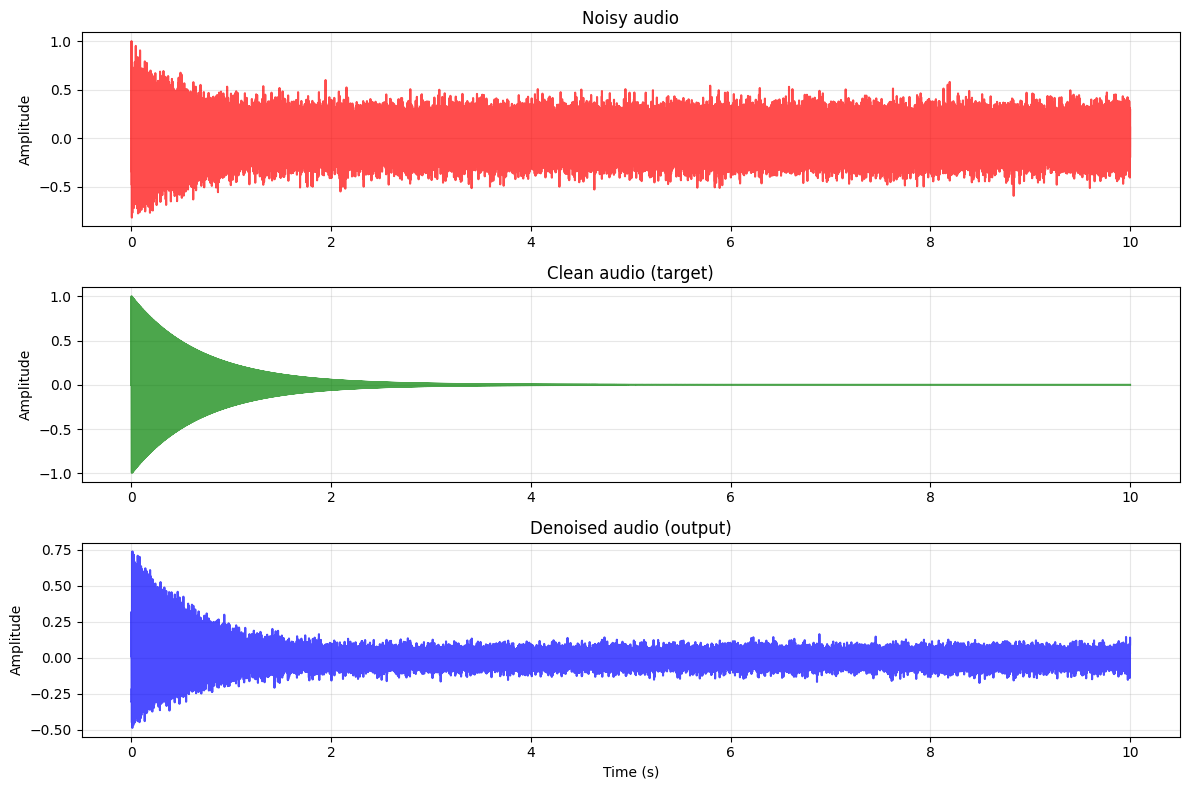


Playing noisy audio:


Playing clean target audio:


Playing denoised audio:


Evaluation metrics:
MSE: 0.004256
Original SNR: -2.33 dB
Denoised SNR: 4.36 dB
SNR improvement: 6.69 dB
Audio denoising training complete


In [6]:

def main():
    print("=== Audio Denoising with LRUUnet ===")

    # Single 10-second synthetic sample
    dataset = AudioDenoisingDataset(
        num_samples=1,
        sample_rate=16000,
        max_length=16000 * 10,   # 10 seconds
    )

    model = LRUUnet(
        in_channels=1,
        out_channels=1,
        channels=[4, 8],
        resample_factors=[4, 4],
        pre_conv=False,
        causal=True,
    )

    model, history = train_audio_denoiser(
        model=model,
        dataset=dataset,
        epochs=1,        
        batch_size=1,
        learning_rate=1e-2,
        device="auto",
        steps=1000,      # number of gradient steps on the same sample
    )

    visualize_denoising(model, dataset, sample_idx=0)

    return model, history


if __name__ == "__main__":
    trained_model, training_history = main()
    print("Audio denoising training complete")


## Visual Results Analysis


### Noisy Audio Input (Top Panel - Red)

-   **Observation**: The top panel clearly shows a clean signal almost entirely masked by pervasive white noise. The underlying structure is barely discernible.

### Clean Audio Target (Middle Panel - Green)

-   **Observation**: This panel displays the pristine target signal, a decaying sinusoidal waveform, free from any noise. It serves as the ground truth for denoising.

### Denoised Output (Bottom Panel - Blue)

-   **Observation**: The denoised output closely resembles the clean audio. The model successfully suppressed the white noise, revealing the clear decaying sine wave structure. Minimal artifacts are visible, indicating strong signal reconstruction.

## Architecture Strengths

- The design combines U-Net's encoder-decoder structure with skip connections for local feature preservation and an LRU block for sequence modeling in the bottleneck.
- Custom `Conv1d`-based pooling provides differentiable down/upsampling, which is superior to basic max pooling for learnable temporal scaling.
- Training converges quickly on small synthetic data due to the modest model size and the strong inductive bias from the U-Net + LRU combination.


## Conclusion

This U-Net with LRU integration offers a solid foundation for audio denoising, leveraging multi-scale feature extraction and state-space sequence modeling for effective noise reduction on synthetic waveforms.